In [344]:
import sklearn

In [345]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [346]:
len(X), len(y)

(1000, 1000)

In [347]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})

circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


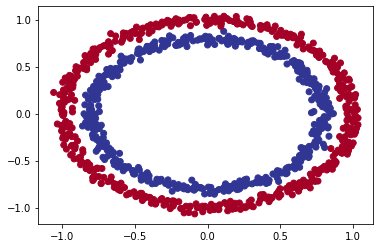

In [348]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [349]:
######### Check inputs and outputs shape

In [350]:
X.shape, y.shape

((1000, 2), (1000,))

In [351]:
############ Turn data into tensors

In [352]:
import torch
torch.__version__

'1.13.0+cu116'

In [353]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [354]:
################ Split into train and test set

In [355]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [356]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [357]:
################# Building a model

In [358]:
import torch
from torch import nn


## Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [359]:
######## construct a model

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [360]:
device

'cpu'

In [361]:
next(model_0.parameters()).device

device(type='cpu')

In [362]:
#### replicating the above model_0 using nn.Sequential()

In [363]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [364]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [365]:
## Making predictions

In [366]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [367]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [368]:
## Accuracy function

In [369]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [370]:
### TRAIN MODEL

In [371]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [372]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [373]:
##### use sigmoid activatin function on our model logits to turn them into prediction probablities

In [374]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

In [375]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

In [376]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [377]:
#### Building a training and testing loop

In [378]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    ## 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    ## 2. Calculate the loss / accuracy

    # loss = loss_fn(torch.sigmoid(y_logits),
    #                y_train) // nn.BCELoss expects prediction


    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred= test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}  | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    


Epoch: 0  | Loss: 0.69796, Acc: 51.88% | Test Loss: 0.69440, Test acc: 58.00%
Epoch: 10  | Loss: 0.69590, Acc: 51.25% | Test Loss: 0.69305, Test acc: 53.00%
Epoch: 20  | Loss: 0.69490, Acc: 51.62% | Test Loss: 0.69254, Test acc: 49.50%
Epoch: 30  | Loss: 0.69435, Acc: 51.12% | Test Loss: 0.69236, Test acc: 49.50%
Epoch: 40  | Loss: 0.69401, Acc: 50.88% | Test Loss: 0.69232, Test acc: 51.00%
Epoch: 50  | Loss: 0.69378, Acc: 50.25% | Test Loss: 0.69234, Test acc: 50.00%
Epoch: 60  | Loss: 0.69362, Acc: 50.00% | Test Loss: 0.69239, Test acc: 51.50%
Epoch: 70  | Loss: 0.69351, Acc: 50.25% | Test Loss: 0.69246, Test acc: 51.00%
Epoch: 80  | Loss: 0.69342, Acc: 49.88% | Test Loss: 0.69254, Test acc: 50.00%
Epoch: 90  | Loss: 0.69336, Acc: 49.88% | Test Loss: 0.69262, Test acc: 53.00%


In [379]:
import requests
from pathlib import Path

if Path("helper_function.py").is_file():
    print("helper_function.py already exists, skipping download")

else:
    print("Dowload helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Dowload helper_functions.py


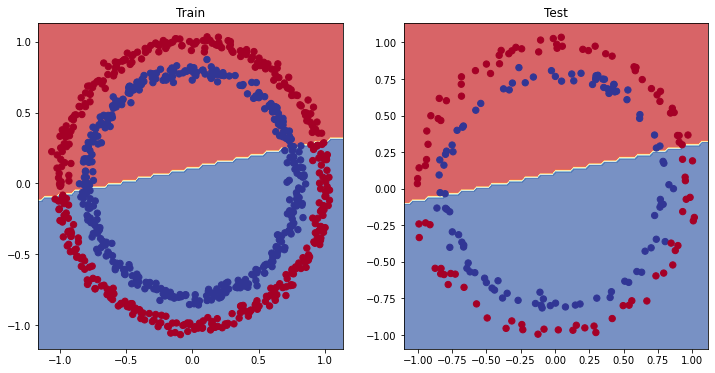

In [380]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [381]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.0849, -0.2762],
                      [ 0.4610, -0.5187],
                      [-0.3271, -0.1947],
                      [-0.4220,  0.0507],
                      [-0.7016,  0.6600]])),
             ('0.bias', tensor([-0.6060,  0.5246,  0.1149, -0.2211,  0.4275])),
             ('1.weight',
              tensor([[ 0.0741,  0.2406,  0.0222, -0.1075,  0.1965]])),
             ('1.bias', tensor([-0.1888]))])

In [382]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z =  self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1


# class CircleModelV1(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layer_1 = nn.Linear(in_features=2, out_features=10)
#         self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
#         self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
#     def forward(self, x): # note: always make sure forward is spelt correctly!
#         # Creating a model like this is the same as below, though below
#         # generally benefits from speedups where possible.
#         # z = self.layer_1(x)
#         # z = self.layer_2(z)
#         # z = self.layer_3(z)
#         # return z
#         return self.layer_3(self.layer_2(self.layer_1(x)))

# model_1 = CircleModelV1().to(device)
# model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [383]:
model_1.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310,  0.1000, 

In [384]:
# model_1(X_train)

In [385]:
######## Ceate a loss function
loss_fn = nn.BCEWithLogitsLoss()

######## Create an optimizer
optimizer = torch.optim.SGD(params= model_1.parameters(),
                            lr=0.1)

####### Write a training and evaluatin loop for model_1
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# train for longer
epochs = 1000

# put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true= y_test,
                            y_pred = test_pred)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test Loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test Loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test Loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%


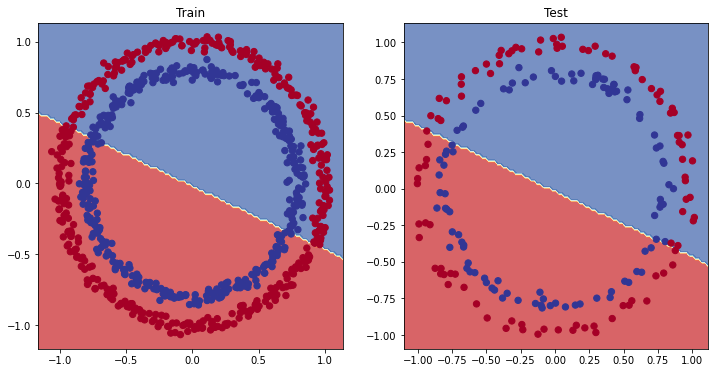

In [386]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [387]:
####################

In [388]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [389]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

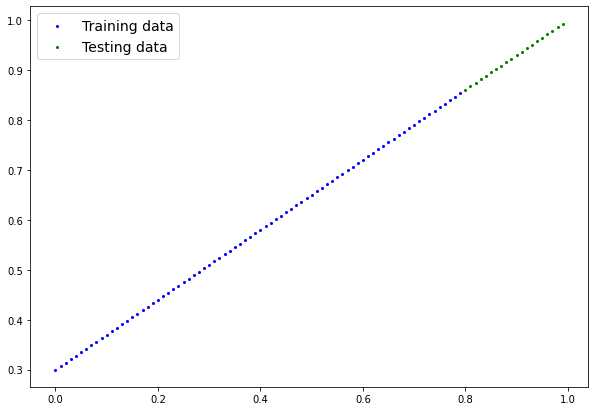

In [390]:
plot_predictions(train_data=X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)

In [391]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [392]:
model_2 = nn.Sequential(
    nn.Linear(in_features = 1, out_features = 10),
    nn.Linear(in_features = 10, out_features = 10),
    nn.Linear(in_features = 10, out_features = 1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [393]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr = 0.01)
                                      

In [394]:
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360


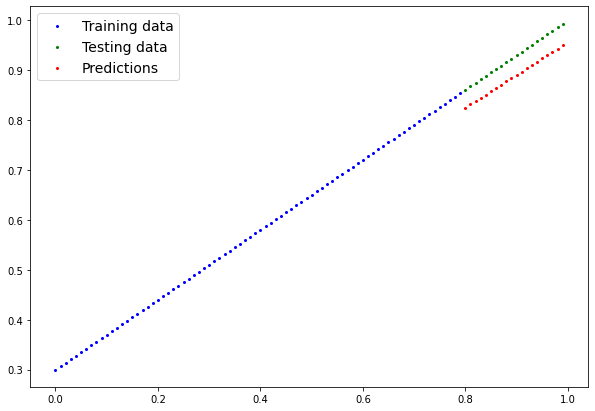

In [395]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels = y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = y_test_regression.cpu(),
                 predictions=y_preds.cpu())

In [396]:
### Recreating non linear data

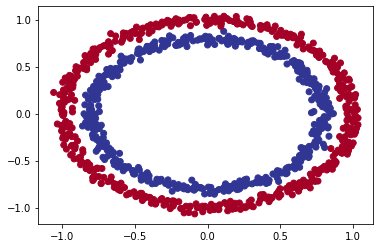

In [397]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap= plt.cm.RdYlBu);

In [398]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

In [399]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [400]:
###### Setup loss and optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)


In [401]:
# Training a model with non linearity

In [402]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred= test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295 | Acc: 50.00% | Test Loss: 0.69319 | Test Acc: 50.00%
Epoch: 100 | Loss: 0.69115 | Acc: 52.88% | Test Loss: 0.69102 | Test Acc: 52.50%
Epoch: 200 | Loss: 0.68977 | Acc: 53.37% | Test Loss: 0.68940 | Test Acc: 55.00%
Epoch: 300 | Loss: 0.68795 | Acc: 53.00% | Test Loss: 0.68723 | Test Acc: 56.00%
Epoch: 400 | Loss: 0.68517 | Acc: 52.75% | Test Loss: 0.68411 | Test Acc: 56.50%
Epoch: 500 | Loss: 0.68102 | Acc: 52.75% | Test Loss: 0.67941 | Test Acc: 56.50%
Epoch: 600 | Loss: 0.67515 | Acc: 54.50% | Test Loss: 0.67285 | Test Acc: 56.00%
Epoch: 700 | Loss: 0.66659 | Acc: 58.38% | Test Loss: 0.66322 | Test Acc: 59.00%
Epoch: 800 | Loss: 0.65160 | Acc: 64.00% | Test Loss: 0.64757 | Test Acc: 67.50%
Epoch: 900 | Loss: 0.62362 | Acc: 74.00% | Test Loss: 0.62145 | Test Acc: 79.00%


In [403]:
model_3.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.6760,  0.8035],
                      [-0.1997,  0.7568],
                      [-0.1549,  0.1427],
                      [-0.9637,  0.2292],
                      [ 0.5717, -1.3426],
                      [ 0.6689,  0.1840],
                      [ 0.7970,  0.2595],
                      [ 0.3410, -0.0998],
                      [ 0.6555,  0.3186],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3761, -0.2008, -0.2872,  0.2803, -0.4513, -0.3364, -0.3300, -0.4252,
                      -0.1989, -0.6984])),
             ('layer_2.weight',
              tensor([[ 1.3081e-01, -3.7347e-01,  2.4414e-01, -4.3348e-02, -2.7270e-01,
                        1.0512e-01, -4.7109e-02,  2.5550e-01, -4.9248e-02, -9.9730e-02],
                      [ 7.9469e-01,  3.8277e-01,  1.3309e-01,  7.5399e-01,  9.7241e-01,
                        2.6996e-01,  6.2185e-01,  5.6581e-02,  5.3486e-01, -1.9274e-01],
      

In [404]:
# make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_pred[:10], y_test[:10]

(tensor([1., 0., 0., 0., 1., 1., 1., 1., 0., 0.], grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

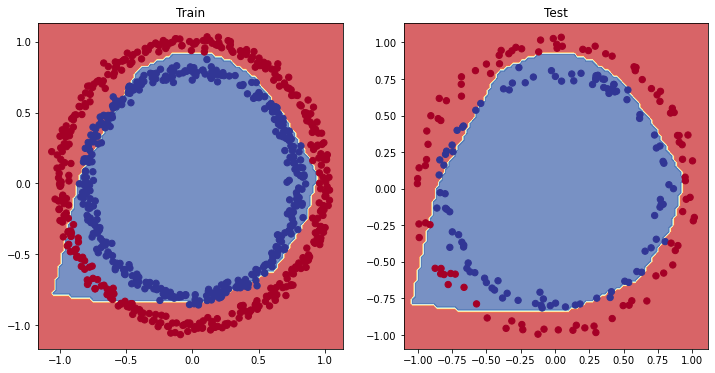

In [405]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [406]:
######## eplicating non linear activation function


In [407]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [408]:
type(A)

torch.Tensor

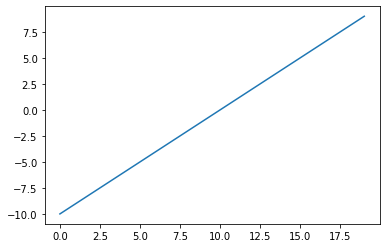

In [409]:
plt.plot(A);

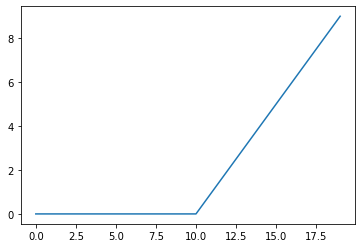

In [410]:
plt.plot(torch.relu(A));

In [411]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

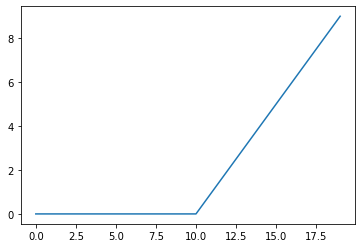

In [412]:
plt.plot(relu(A))

In [413]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

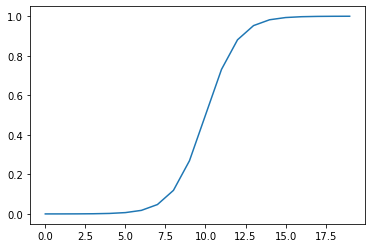

In [414]:
plt.plot(sigmoid(A))

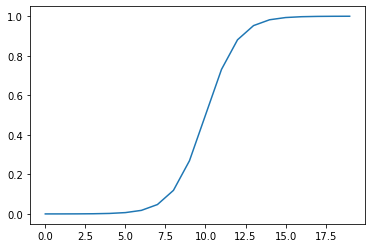

In [415]:
plt.plot(torch.sigmoid(A));

In [416]:
#########################################################

In [417]:
## Multi class classification

In [418]:
## Creating a toy multi class dataset


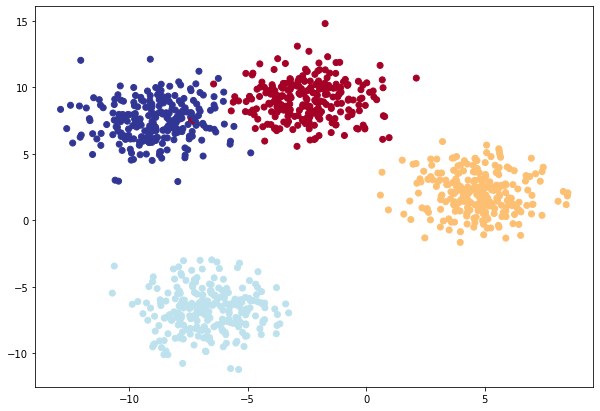

In [419]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap = plt.cm.RdYlBu);

In [420]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [421]:
## build a multi class classification mode

In [422]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features = 2,
                    output_features = 4,
                    hidden_units=8).to(device)

model_4

    

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [423]:
######## loss function and optimizer

In [424]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

In [425]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test).to(device)

y_logits[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]])

In [426]:
next(model_4.parameters()).device

device(type='cpu')

In [427]:
X_blob_test.device

device(type='cpu')

In [428]:
y_blob_test[:10] ######### y_blob_test and y_logits are in different form

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [429]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])


In [430]:
torch.sum(y_pred_probs[0])

tensor(1.)

In [431]:
torch.max(y_pred_probs[0])

tensor(0.3715)

In [432]:
torch.argmax(y_pred_probs[0])

tensor(3)

In [433]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

In [434]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [435]:
### Creating a training loop and testting loop

In [436]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [437]:
y_blob_train[:5]

tensor([1, 0, 2, 2, 0])

In [438]:
y_logits

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940],
        [ 0.4418, -1.3851,  0.3083,  1.2086],
        [-1.5169, -0.8383, -1.7723, -0.7571],
        [-0.2796, -1.6213, -0.5212,  0.8142],
        [ 0.0087, -1.6676, -0.2100,  1.0779],
        [-0.1146, -1.7781, -0.3619,  1.0633],
        [ 1.4046, -1.2270,  1.3925,  1.8533],
        [ 1.7991, -1.2295,  1.8271,  2.1682],
        [ 1.7553,  0.1992,  1.9850,  1.0572],
        [ 1.7293, -1.4932,  1.7121,  2.3114],
        [ 2.0059, -0.9975,  2.0886,  2.1575],
        [ 1.3878, -1.3971,  1.3495,  1.9682],
        [ 0.2662, -1.2199,  0.1385

In [439]:
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_preds)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} , Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.0432 , Acc: 65.50% | Test Loss: 0.5786, Test acc: 95.50%
Epoch: 10 | Loss: 0.1440 , Acc: 99.12% | Test Loss: 0.1304, Test acc: 99.00%
Epoch: 20 | Loss: 0.0806 , Acc: 99.12% | Test Loss: 0.0722, Test acc: 99.50%
Epoch: 30 | Loss: 0.0592 , Acc: 99.12% | Test Loss: 0.0513, Test acc: 99.50%
Epoch: 40 | Loss: 0.0489 , Acc: 99.00% | Test Loss: 0.0410, Test acc: 99.50%
Epoch: 50 | Loss: 0.0429 , Acc: 99.00% | Test Loss: 0.0349, Test acc: 99.50%
Epoch: 60 | Loss: 0.0391 , Acc: 99.00% | Test Loss: 0.0308, Test acc: 99.50%
Epoch: 70 | Loss: 0.0364 , Acc: 99.00% | Test Loss: 0.0280, Test acc: 99.50%
Epoch: 80 | Loss: 0.0345 , Acc: 99.00% | Test Loss: 0.0259, Test acc: 99.50%
Epoch: 90 | Loss: 0.0330 , Acc: 99.12% | Test Loss: 0.0242, Test acc: 99.50%


In [440]:
### Making and evaluating predictions

In [441]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [442]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.4332e-03, 9.9757e-01, 1.0804e-11, 1.8271e-09],
        [3.4828e-03, 1.3697e-10, 6.8363e-04, 9.9583e-01],
        [2.8657e-12, 1.2266e-15, 9.9973e-01, 2.6959e-04],
        [3.2692e-03, 9.9673e-01, 9.5435e-08, 4.7619e-07],
        [9.9168e-01, 8.3089e-03, 1.4120e-10, 8.2969e-06],
        [4.5039e-04, 5.4287e-13, 2.5532e-04, 9.9929e-01],
        [1.6306e-11, 2.4030e-13, 9.9987e-01, 1.3003e-04],
        [9.9860e-01, 3.9485e-04, 5.9937e-08, 1.0045e-03],
        [3.0436e-14, 6.8303e-20, 9.9965e-01, 3.5218e-04],
        [9.9843e-01, 1.3657e-03, 9.0767e-09, 2.0006e-04]])

In [443]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [444]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

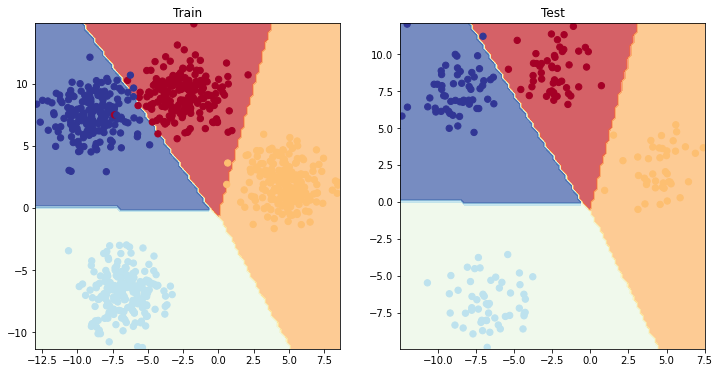

In [445]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [446]:
### classification metrics

In [447]:
!pip install torchmetrics -q

In [449]:
# from torchmetrics import Accuracy

# torchmetric_accuracy = Accuracy().to(device)

# torchmetric_accuracy(y_preds, y_blob_test)